In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/movies_PREPROCESADA.csv")
df.shape

(4998, 62)

In [3]:
df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,actor_1_name,movie_title,num_voted_users,...,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_others,CR_grouped_Adult,CR_grouped_Family,CR_grouped_Other,CR_grouped_Teen,CR_grouped_Unrated
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,CCH Pounder,Avatar,886204.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,Johnny Depp,Pirates of the Caribbean: At World's End,471220.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,Christoph Waltz,Spectre,275868.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,Tom Hardy,The Dark Knight Rises,1144337.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'budget_filled', 'gross_filled', 'imdb_category', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western',
       'continent_Africa', 'continent_Asia', 'continent_Europe',
       'continent_North America', 'continent_Oceania',
       'continent_South America', 'continen

In [5]:
#limpiar movie_title, ya que es una columna importante más adelante

df["movie_title"] = (
    df["movie_title"]
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

In [6]:
#columnas a excluir para el random forest

cols_excluir = [
    "director_name",
    "actor_1_name",
    "actor_2_name",
    "actor_3_name",
    "movie_title",
    "title_year",
    "language",
    "movie_imdb_link",
    "plot_keywords"
]

df_rf = df.drop(columns=cols_excluir)

In [7]:
df_rf.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'budget_filled', 'gross_filled',
       'imdb_category', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'continent_Africa', 'continent_Asia',
       'continent_Europe', 'continent_North America', 'continent_Oceania',
       'continent_South America', 'continent_others', 'CR_grouped_Adult',
       'CR_grouped_Family', 'CR_grouped_Other', 'CR_grouped_Teen',
       'CR_grouped_Unrated'],
      dtype='object')

In [9]:
#ver el porcentaje que representa cada categoría
df_category = df_rf["imdb_category"].value_counts()

lista = []
for i in range(len(df_category)):
  proporcion = df_category[i] / df_rf.shape[0]
  lista.append(round(proporcion*100, 2))

df_category = pd.DataFrame(df_category)
df_category.insert(loc = 1, column = "porcentaje", value = lista)

df_category

,count,porcentaje
imdb_category,,
Neutral,1798,35.97
Good,1759,35.19
Not Good,1441,28.83


###**DIVIDIR EL DATASET: TRAINING, VALIDATION, TEST**

In [10]:
#división del dataset: 0.70-0.15-0.15

# Extraer t
T_c, t= train_test_split(df_rf, test_size=0.15, random_state=42,  stratify= df_rf["imdb_category"] )

# Extraer T, V
V, T = train_test_split(T_c, train_size=0.15/0.85, random_state=42, stratify= T_c["imdb_category"])

print("Tamaño del dataset Training", T.shape)
print("Tamaño del dataset Validation", V.shape)
print("Tamaño del dataset Test", t.shape)


Tamaño del dataset Training (3499, 53)
Tamaño del dataset Validation (749, 53)
Tamaño del dataset Test (750, 53)


### **Imputar nulos basando en métricas de training**

In [11]:
#Ver cantidad de nulos del dataset de training
T.isnull().sum()

,0
num_critic_for_reviews,34
duration,11
director_facebook_likes,62
actor_3_facebook_likes,20
actor_1_facebook_likes,7
num_voted_users,1
cast_total_facebook_likes,1
facenumber_in_poster,10
num_user_for_reviews,15
actor_2_facebook_likes,12


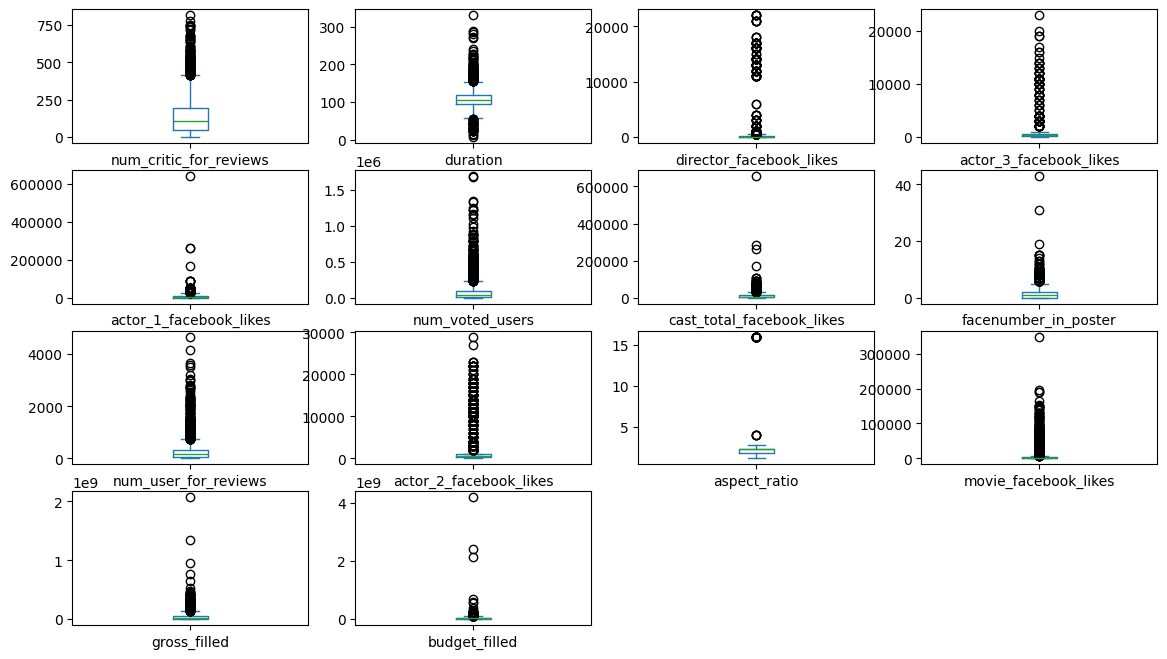

In [12]:
#ver distribución de duration
val_numericas = ["num_critic_for_reviews",
"duration",
"director_facebook_likes",
"actor_3_facebook_likes",
"actor_1_facebook_likes",
"num_voted_users",
"cast_total_facebook_likes",
"facenumber_in_poster",
"num_user_for_reviews",
"actor_2_facebook_likes",
"aspect_ratio",
"movie_facebook_likes",
"gross_filled",
"budget_filled"]

T[val_numericas].plot(kind='box',subplots=True, layout=(4,4), sharex=False,sharey=False, figsize=(14,8))
plt.show()

#Tiene muchos atípicos, así que se imputará con la mediana

In [13]:
#imputar con la mediana
T[val_numericas] = T[val_numericas].fillna(T[val_numericas].median())
#verificar la cantidad de nulo
T.isnull().sum()

,0
num_critic_for_reviews,0
duration,0
director_facebook_likes,0
actor_3_facebook_likes,0
actor_1_facebook_likes,0
num_voted_users,0
cast_total_facebook_likes,0
facenumber_in_poster,0
num_user_for_reviews,0
actor_2_facebook_likes,0


In [14]:
#imputar en el dataset de test y validation el valor de la mediana de training
t[val_numericas] = t[val_numericas].fillna(T[val_numericas].median())
V[val_numericas] = V[val_numericas].fillna(T[val_numericas].median())
print("Cantidad de nulos de dataset test:")
print(t.isnull().sum())
print("")
print("Cantidad de nulos de dataset validation:")
print(V.isnull().sum())

Cantidad de nulos de dataset test:
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
num_user_for_reviews         0
actor_2_facebook_likes       0
aspect_ratio                 0
movie_facebook_likes         0
budget_filled                0
gross_filled                 0
imdb_category                0
Action                       0
Adventure                    0
Animation                    0
Biography                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Family                       0
Fantasy                      0
Film-Noir                    0
Game-Show                    0
History                      0
Horror                       0
Music                        0
Musical                      0
Myst

### **Separar X e Y**

In [15]:
#Separar las X e Y de cada dataset
X_T = T.drop(columns=["imdb_category"])
y_T = T["imdb_category"]

X_V = V.drop(columns=["imdb_category"])
y_V = V["imdb_category"]

X_t = t.drop(columns=["imdb_category"])
y_t = t["imdb_category"]

In [16]:
print(X_T.shape)
print(y_T.shape)
print(X_V.shape)
print(y_V.shape)
print(X_t.shape)
print(y_t.shape)


(3499, 52)
(3499,)
(749, 52)
(749,)
(750, 52)
(750,)


In [17]:
X_T.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'budget_filled', 'gross_filled', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western',
       'continent_Africa', 'continent_Asia', 'continent_Europe',
       'continent_North America', 'continent_Oceania',
       'continent_South America', 'continent_others', 'CR_grouped_Adult',
       'CR_grouped_Family', 'CR_grouped_Other', 'CR_grouped_Teen',
       'CR_grouped_Unrated'],
      dtype='object')

In [18]:
#El orden de los nombres de las columnas se encuentra en desorden, entonces lo
#reordenamos usando la función reindex

feat_cols = list(X_T.columns)

X_V = X_V.reindex(columns=feat_cols)
X_t = X_t.reindex(columns=feat_cols)

###**Primer modelo con los hiperparámetros por defecto**

In [49]:
#Probar con los hiperparámetros por defecto

modelo_0 = RandomForestClassifier(random_state= 42,class_weight="balanced")

modelo_0.fit(X_T, y_T)

# predicciones
y_train_pred = modelo_0.predict(X_T)
y_val_pred = modelo_0.predict(X_V)

# recall en train y validation
recall_T = round(recall_score(y_T, y_train_pred, average='weighted'),2)
recall_V = round(recall_score(y_V, y_val_pred, average='weighted'),2)

print("El recall de training es:", recall_T)
print("El recall de validation es:", recall_V)

El recall de training es: 1.0
El recall de validation es: 0.68


In [50]:
print(classification_report(y_V, y_val_pred))

              precision    recall  f1-score   support

        Good       0.72      0.74      0.73       264
     Neutral       0.61      0.58      0.60       269
    Not Good       0.71      0.73      0.72       216

    accuracy                           0.68       749
   macro avg       0.68      0.68      0.68       749
weighted avg       0.68      0.68      0.68       749



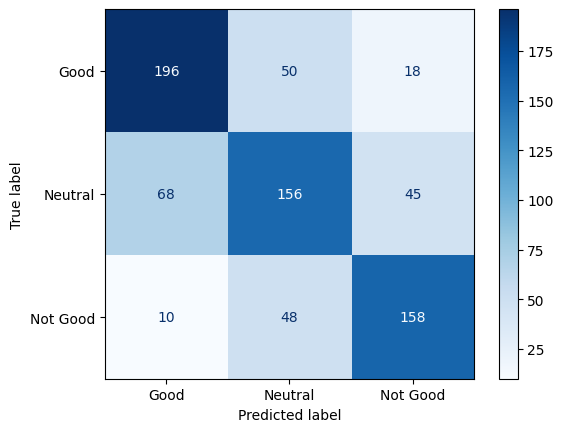

In [51]:
matriz = confusion_matrix(y_V, y_val_pred, labels=modelo_0.classes_)

# mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=modelo_0.classes_)
disp.plot(cmap="Blues")

###**Optimizar hiperparámetros y resultados**

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Definir rango de hiperparámetros
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [7, 10],
    "min_samples_split": [10, 20],
    "min_samples_leaf": [5, 10],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42,class_weight="balanced")

#para balancear el recall
recall_scorer = make_scorer(recall_score, average='weighted', zero_division=0)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring= recall_scorer,
    cv=skf,
    n_jobs=-1
)

# Entrenamiento
grid.fit(X_T, y_T)

# Mejor modelo
print("Mejor configuración:", grid.best_params_)

Mejor configuración: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


In [65]:
#P: 10 || D:20 || h:15
X_TV = pd.concat([X_T, X_V], axis = 0)
y_TV = pd.concat([y_T, y_V], axis = 0)

modelo = RandomForestClassifier(
        n_estimators=300,
        max_depth=7,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42
    )

# Entrenar
modelo.fit(X_TV, y_TV)

# Predicciones
Y_pred_t = modelo.predict(X_t)

# Recall
rec_t = recall_score(y_t, Y_pred_t, average='weighted')
print(round(rec_t,2))

0.61


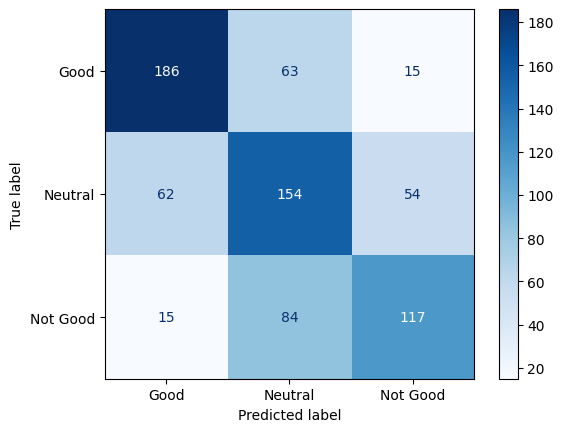

In [66]:
matriz = confusion_matrix(y_t, Y_pred_t, labels=modelo.classes_)

# mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=modelo.classes_)
disp.plot(cmap="Blues")

In [69]:
#classification_report
print(classification_report(y_t, Y_pred_t))

              precision    recall  f1-score   support

        Good       0.71      0.70      0.71       264
     Neutral       0.51      0.57      0.54       270
    Not Good       0.63      0.54      0.58       216

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



In [70]:
#ver importancia de los features
importancias = modelo.feature_importances_

# Crear dataframe ordenado
feat_importances = pd.DataFrame({
    "feature": X_TV.columns,
    "importance": importancias
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                      feature  importance
5             num_voted_users    0.183171
1                    duration    0.097684
21                      Drama    0.094556
8        num_user_for_reviews    0.083736
11       movie_facebook_likes    0.066613
0      num_critic_for_reviews    0.054642
12              budget_filled    0.052257
13               gross_filled    0.042729
2     director_facebook_likes    0.034764
3      actor_3_facebook_likes    0.031262
6   cast_total_facebook_likes    0.030059
9      actor_2_facebook_likes    0.029328
27                     Horror    0.021815
4      actor_1_facebook_likes    0.020593
10               aspect_ratio    0.016620
20                Documentary    0.016141
14                     Action    0.015838
50            CR_grouped_Teen    0.012763
17                  Biography    0.012622
18                     Comedy    0.012492
37                   Thriller    0.009943
43    continent_North America    0.009119
7        facenumber_in_poster    0

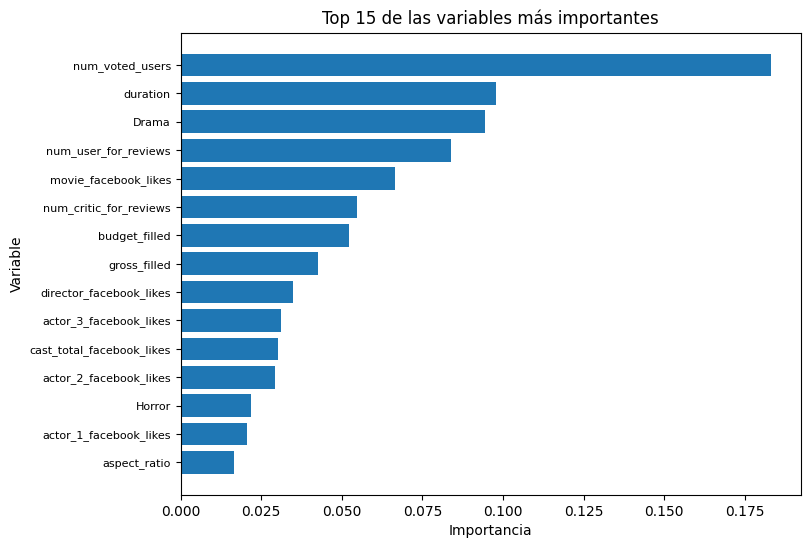

In [75]:
#graficar features más importantes
plt.figure(figsize=(8,6))
plt.barh(feat_importances["feature"][:15][::-1],
         feat_importances["importance"][:15][::-1])
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.yticks(fontsize=8)
plt.title("Top 15 de las variables más importantes")
plt.show()

### --------- SISTEMA DE RECOMENDACIÓN ---------

In [76]:
#matriz de similitud

columns_sistema = []
for c in df_rf.columns:
  if c != "imdb_category":
    columns_sistema.append(c)

# matriz para similitud
matriz_sim = df_rf[columns_sistema].copy()

#analizar nulos
matriz_sim.isnull().sum()

,0
num_critic_for_reviews,49
duration,15
director_facebook_likes,103
actor_3_facebook_likes,23
actor_1_facebook_likes,7
num_voted_users,1
cast_total_facebook_likes,1
facenumber_in_poster,13
num_user_for_reviews,22
actor_2_facebook_likes,14


In [77]:
#como hay nulos y son asimétricos, se imputa con la mediana
matriz_sim = matriz_sim.fillna(matriz_sim.median())

#comprobación
matriz_sim.isnull().sum()

,0
num_critic_for_reviews,0
duration,0
director_facebook_likes,0
actor_3_facebook_likes,0
actor_1_facebook_likes,0
num_voted_users,0
cast_total_facebook_likes,0
facenumber_in_poster,0
num_user_for_reviews,0
actor_2_facebook_likes,0


In [78]:
# normalizar valores numéricos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
matriz_norm = scaler.fit_transform(matriz_sim)

# convertir nuevamente a DataFrame
matriz_norm = pd.DataFrame(matriz_norm, columns=columns_sistema)

In [79]:
from sklearn.metrics.pairwise import cosine_similarity

# calcular la matriz de similitud
sim_matrix = cosine_similarity(matriz_norm)

# Usamos el modelo entrenado (modelo)
df["pred_category"] = modelo.predict(df_rf[columns_sistema])

In [80]:
def recomendar_good(movie_title, n):

     try:
        matches = df[df["movie_title"].str.lower().str.contains(movie_title.lower())]
        # índice de la coincidencia más cercana
        idx = matches.index[0]

        # puntajes de similitud
        sim_scores = list(enumerate(sim_matrix[idx]))

        # orden descendente
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # excluir la misma película
        sim_scores = sim_scores[1:]

        # convertir a DataFrame
        df_sim = pd.DataFrame(sim_scores, columns=["indice", "similitud"])

        # unir con las películas del dataset
        resultados = df_sim.merge(
            df[["movie_title", "pred_category"]],
            left_on="indice",
            right_index=True
        )
        # filtrar
        resultados = resultados[resultados["pred_category"] == "Good"]

        # ordenar por similitud
        resultados = resultados.sort_values("similitud", ascending=False)

        return resultados[["movie_title", "similitud"]].head(n)

     except:
        print("La película no está en el dataset.")
        return ""


In [81]:
def recomendar_neutral_not_good(movie_title, n):
    try:
        matches = df[df["movie_title"].str.lower().str.contains(movie_title.lower())]
          # índice de la coincidencia más cercana
        idx = matches.index[0]

        # puntajes de similitud
        sim_scores = list(enumerate(sim_matrix[idx]))

        # orden descendente
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # excluir la misma película
        sim_scores = sim_scores[1:]

        # convertir a DataFrame
        df_sim = pd.DataFrame(sim_scores, columns=["indice", "similitud"])

        # unir con las películas del dataset
        resultados = df_sim.merge(
            df[["movie_title", "pred_category"]],
            left_on="indice",
            right_index=True
        )
        # filtrar
        resultados = resultados[(resultados["pred_category"] == "Neutral") | (resultados["pred_category"] == "Not Good")]

        # ordenar por similitud
        resultados = resultados.sort_values("similitud", ascending=False)

        return resultados[["movie_title", "similitud"]].head(n)

    except:
        print("La película no está en el dataset.")
        return ""


In [82]:
while True:
  title = input("Ingrese la película: ")
  if title == "salir":
    break

  else:
    n = int(input("Ingrese cantidad de películas similares a buscar: "))

    print(f"\nTop {n} películas mejores valoradas similares a {title} -------------------------------------")
    print(recomendar_good(title, n))
    print("\n")
    print(f"También te pueden gustar ----------------------------------------------------------------")
    print(recomendar_neutral_not_good(title, n))


Ingrese la película: avatar
Ingrese cantidad de películas similares a buscar: 5

Top 5 películas mejores valoradas similares a avatar -------------------------------------
                                    movie_title  similitud
0                                  Man of Steel   0.988996
1  Star Wars: Episode III - Revenge of the Sith   0.978241
2                      The Amazing Spider-Man 2   0.972809
4                                    Iron Man 3   0.913824
5                        The Amazing Spider-Man   0.913137


También te pueden gustar ----------------------------------------------------------------
                                  movie_title  similitud
3       The League of Extraordinary Gentlemen   0.936988
8                            Superman Returns   0.907112
17        Transformers: Revenge of the Fallen   0.902939
23                       Terminator Salvation   0.895114
28  Beastmaster 2: Through the Portal of Time   0.893107
Ingrese la película: X-men
Ingrese canti

KeyboardInterrupt: Interrupted by user